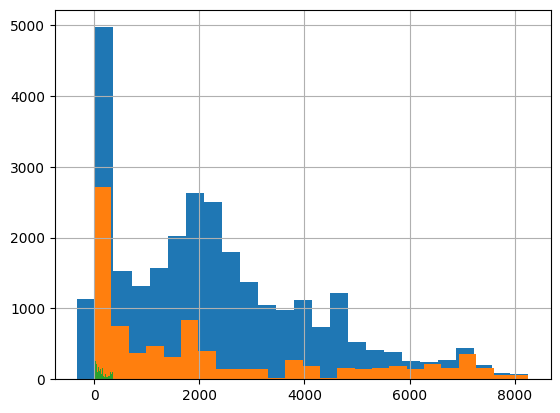

In [1]:
import pandas as pd
import datetime
import numpy as np

CSV_ROWS = [
    "Photo_Name",
    "Id",
    "Sex",
    "dob",
    "dob_estimated",
    "error_dob",
    "FaceView",
    "FaceQual",
    "Shootdate"
]

def csvdate_to_date(shoot_date):
    year, month, day = shoot_date.split("-")
    return datetime.date(int(year), int(month), int(day))    

def compute_age(row):
    photo_date = csvdate_to_date(row["Shootdate"])
    dob_date = csvdate_to_date(row["dob"])
    age = photo_date - dob_date
    return age.days

def add(row):
   return row[0]+row[1]+row[2]

data = pd.read_csv("MFD_metadatas.csv", dtype={'Shootdate': str})
data['Shootdate'].replace('nan', np.nan, inplace=True)
data = data.dropna()
data['age'] = data.apply(compute_age, axis=1)

def filter_by_age(data, age_in_days):
    return data[data['age'] <= age_in_days]

def filter_by_certainty(data):
    return data[data['dob_estimated'] == False]

def filter_dob_errors(data):
    return data[data["age"] >= 0]

data["age"].hist(bins=25)

data = filter_by_certainty(data)
data = filter_dob_errors(data)
data.reset_index(inplace=True, drop=True)

data["age"].hist(bins=25)

max_days = 365

one_year_data = filter_by_age(data, age_in_days=max_days)
one_year_data.reset_index(drop=True, inplace=True)

hist = one_year_data["age"].hist(bins=25)




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm
import random

# Define your custom dataset
class MandrillImageDataset(Dataset):
    def __init__(self, root_dir, dataframe, img_size=(224, 224), device="cuda", in_mem=True):
        self.df = dataframe
        self.root_dir = root_dir
        self.img_size = img_size
        self.in_mem = in_mem
        if self.in_mem:
            self.images = []
            for i in tqdm(range(len(self.df))):
                row = self.df.iloc[[i]]
                self.images.append(self.load_photo(row))

    def load_photo(self, row):
        image_path = self.photo_path(row)
        image = cv2.imread(image_path)
        if image.shape[0:2] != self.img_size:
            image = cv2.resize(image, self.img_size, interpolation = cv2.INTER_AREA)
        image = np.moveaxis(image, -1, 0) # Channel first format
        image = image.astype(np.float32) / 255.0
        return image
            
    def photo_path(self, row):
        return os.path.join(self.root_dir, f"{row['Id'].values[0]}", f"{row['Photo_Name'].values[0]}")
        
    def __len__(self):
        return len(self.df)
    
    def _getpair(self, idx):
        row = self.df.iloc[[idx]]

        target = float(row["age"].values[0])
        target = target / 365

        if self.in_mem:
            image = self.images[idx]
        else:
            image = self.load_photo(row)
        return torch.tensor(image).to(device), torch.tensor(target).to(device)
    
    def __getitem__(self, idx):
        return self._getpair(idx)

class MandrillDualImageDataset(MandrillImageDataset):
    def __init__(self, root_dir, dataframe, img_size=(224, 224), device="cuda", in_mem=True):
        super(MandrillDualImageDataset, self).__init__(root_dir, dataframe, img_size, device, in_mem)
        self.max_year_gap = 25
        self.max_days_gap = self.max_year_gap
                    
    def get_same_mandrill_idx(self, mandrill_id):
        ids = self.df[self.df.Id == mandrill_id].index
        return ids
    
    def __getitem__(self, idx):
        # Randomize
        idx = random.randint(0, len(self)-1)
        #row = self.df.iloc[[idx]]
        #mandrill_id = row["Id"].values[0]
        #ids = self.get_same_mandrill_idx(mandrill_id)
        #second_idx = random.choice(ids)
        
        second_idx = random.randint(0, len(self)-1)
        x1, y1 = self._getpair(idx)
        x2, y2 = self._getpair(second_idx)
                
        y1 = y1.cpu().numpy()
        y2 = y2.cpu().numpy()
        return [x1, x2], torch.tensor(np.sign(y1 - y2)).to(device)

# Define your model
from collections import OrderedDict
def build_layers(n, method, prev_features, current_features, down=True):
    layers = OrderedDict()
    for i in range(n):
        layers[str(i)] = method(prev_features, current_features)
        prev_features = current_features
        if down:
            current_features = current_features // 2
        else:
            current_features = current_features * 2
    return layers, prev_features

    
class BackboneRegressionModel(nn.Module):
    def __init__(self, im_size=224, n_channels=3, conv_start=4, n_convs=5):
        super(BackboneRegressionModel, self).__init__()
        previous_feature_size = n_channels
        current_feature_size = conv_start
        convs_layers, last_feature_size = build_layers(
            n_convs, self.conv_block, previous_feature_size, current_feature_size, down=False
        )
        self.conv_blocks = nn.Sequential(convs_layers)
        
        last_scale = (2 ** (n_convs))
        last_size = im_size // last_scale
        self.last_layer_size = last_feature_size * last_size * last_size

    def conv_block(self, in_features, out_features):
        conv = nn.Conv2d(in_features, out_features, 3, padding="same")
        relu = nn.ReLU(inplace=True)
        bn = nn.BatchNorm2d(out_features)
        pool = nn.MaxPool2d((2,2))
        return nn.Sequential(conv, relu, bn, pool)
    
    def forward(self, x):
        return self.conv_blocks(x)

class RegressionModel(nn.Module):
    def __init__(self, cnn_backbone, lin_start=2048, n_lin=6):
        super(RegressionModel, self).__init__()
        self.cnn_backbone = cnn_backbone

        ############ Dense layers ########
        previous_feature_size = self.cnn_backbone.last_layer_size
        current_feature_size = lin_start
        lin_layers, last_feature_size = build_layers(
            n_lin, self.block, previous_feature_size, current_feature_size
        )
        self.blocks = nn.Sequential(lin_layers)
        self.age = nn.Linear(last_feature_size, 1)

    def block(self, in_features, out_features):
        lin = nn.Linear(in_features, out_features)
        relu = nn.ReLU(inplace=True)
        return nn.Sequential(lin, relu)

    def __del__(self):
        del self.conv_blocks
        del self.blocks
        del self.x_coords
        del self.y_coords

    def forward(self, x):
        z = self.cnn_backbone(x)
        z = torch.reshape(z, (z.shape[0], z.shape[1] * z.shape[2] * z.shape[3]))
        z = self.blocks(z)
        z = self.age(z)
        z = torch.reshape(z, (z.shape[0],))
        return z

class DualRegressionModel(nn.Module):
    def __init__(self, cnn_backbone, lin_start=2048, n_lin=6):
        super(DualRegressionModel, self).__init__()
        self.cnn_backbone = cnn_backbone
        
        previous_feature_size = 2* self.cnn_backbone.last_layer_size
        current_feature_size = lin_start
        lin_layers, last_feature_size = build_layers(
            n_lin, self.block, previous_feature_size, current_feature_size
        )
        self.blocks = nn.Sequential(lin_layers)
        self.age_gap = nn.Linear(last_feature_size, 1)
    
    def block(self, in_features, out_features):
        lin = nn.Linear(in_features, out_features)
        relu = nn.ReLU(inplace=True)
        return nn.Sequential(lin, relu)
    
    def get_z(self, x):
        z = self.cnn_backbone(x)
        z = torch.reshape(z, (z.shape[0], z.shape[1] * z.shape[2] * z.shape[3]))
        return z

    def forward(self, x):
        x1, x2 = x
        z1 = self.get_z(x1)
        z2 = self.get_z(x2)
        z = torch.cat([z1, z2], axis=-1)
        z = self.blocks(z)
        z = self.age_gap(z)
        z = torch.reshape(z, (z.shape[0],))
        return z

learning_rate = 0.001
batch_size = 128
num_epochs = 50
train_ratio = 0.8

# Dataset and DataLoader
dataset = MandrillImageDataset(root_dir='Images', dataframe=one_year_data, in_mem=True)
dual_dataset = MandrillDualImageDataset(root_dir='Images', dataframe=one_year_data, in_mem=True)

def split_dataset(dataset, train_ratio, batch_size):
    # Split the dataset into training and validation subsets
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, train_dataset, val_dataset

train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size)
dual_train_loader, dual_val_loader, _, _ = split_dataset(dual_dataset, train_ratio, batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Model
backbone = BackboneRegressionModel()
backbone = backbone.to(device)
model = RegressionModel(backbone)
dual_model = DualRegressionModel(backbone)

# Loss function
criterion = nn.MSELoss()
val_criterion = nn.L1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dual_optimizer = optim.Adam(model.parameters(), lr=learning_rate)


model = model.to(device)
dual_model = dual_model.to(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    
def train_step(loader, index, optimizer, model, criterion):
    images, labels = next(iter(loader))
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    size = 0
    if isinstance(images, list):
        size = images[0].size(0)
    else:
        size = images.size(0)

    return loss.item() * size
    
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    dual_train_loss = 0.0
    steps = len(train_loader)
    
    for i in tqdm(range(steps)):
        train_loss += train_step(train_loader, i, optimizer, model, criterion)
        dual_train_loss += train_step(dual_train_loader, i, dual_optimizer, dual_model, criterion)
    
    train_loss /= len(train_dataset)
    dual_train_loss /= len(train_dataset)
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            outputs = model(images)
            loss = val_criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    
    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Train Dual loss: {dual_train_loss:.4f} - "
          f"Val L1: {val_loss:.4f}")

100%|██████████| 2948/2948 [00:05<00:00, 502.08it/s]


Using device: cuda

GeForce GTX 980
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB


100%|██████████| 5/5 [00:00<00:00,  8.37it/s]


Epoch [1/50] - Train Loss: 0.1668 - Train Dual loss: 1.0244 - Val L1: 0.1836


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [2/50] - Train Loss: 0.0290 - Train Dual loss: 1.0248 - Val L1: 0.1206


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch [3/50] - Train Loss: 0.0180 - Train Dual loss: 1.0115 - Val L1: 0.0940


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [4/50] - Train Loss: 0.0150 - Train Dual loss: 1.0136 - Val L1: 0.0900


100%|██████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch [5/50] - Train Loss: 0.0106 - Train Dual loss: 1.0044 - Val L1: 0.0802


100%|██████████| 5/5 [00:00<00:00,  9.02it/s]


Epoch [6/50] - Train Loss: 0.0080 - Train Dual loss: 1.0018 - Val L1: 0.0782


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


Epoch [7/50] - Train Loss: 0.0074 - Train Dual loss: 0.9963 - Val L1: 0.0793


100%|██████████| 5/5 [00:00<00:00,  8.53it/s]


Epoch [8/50] - Train Loss: 0.0068 - Train Dual loss: 0.9893 - Val L1: 0.0773


100%|██████████| 5/5 [00:00<00:00,  9.02it/s]


Epoch [9/50] - Train Loss: 0.0040 - Train Dual loss: 0.9863 - Val L1: 0.0769


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch [10/50] - Train Loss: 0.0052 - Train Dual loss: 0.9761 - Val L1: 0.0767


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch [11/50] - Train Loss: 0.0052 - Train Dual loss: 0.9760 - Val L1: 0.0762


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [12/50] - Train Loss: 0.0037 - Train Dual loss: 0.9662 - Val L1: 0.0720


100%|██████████| 5/5 [00:00<00:00,  8.83it/s]


Epoch [13/50] - Train Loss: 0.0040 - Train Dual loss: 0.9599 - Val L1: 0.0732


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [14/50] - Train Loss: 0.0037 - Train Dual loss: 0.9586 - Val L1: 0.0748


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch [15/50] - Train Loss: 0.0042 - Train Dual loss: 0.9563 - Val L1: 0.0735


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch [16/50] - Train Loss: 0.0036 - Train Dual loss: 0.9505 - Val L1: 0.0710


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [17/50] - Train Loss: 0.0038 - Train Dual loss: 0.9508 - Val L1: 0.0711


100%|██████████| 5/5 [00:00<00:00,  8.65it/s]


Epoch [18/50] - Train Loss: 0.0049 - Train Dual loss: 0.9451 - Val L1: 0.0723


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [19/50] - Train Loss: 0.0038 - Train Dual loss: 0.9356 - Val L1: 0.0643


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch [20/50] - Train Loss: 0.0026 - Train Dual loss: 0.9403 - Val L1: 0.0631


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch [21/50] - Train Loss: 0.0032 - Train Dual loss: 0.9285 - Val L1: 0.0644


100%|██████████| 5/5 [00:00<00:00,  8.90it/s]


Epoch [22/50] - Train Loss: 0.0024 - Train Dual loss: 0.9312 - Val L1: 0.0656


100%|██████████| 5/5 [00:00<00:00,  8.74it/s]


Epoch [23/50] - Train Loss: 0.0027 - Train Dual loss: 0.9260 - Val L1: 0.0642


100%|██████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch [24/50] - Train Loss: 0.0021 - Train Dual loss: 0.9187 - Val L1: 0.0629


100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch [25/50] - Train Loss: 0.0015 - Train Dual loss: 0.9217 - Val L1: 0.0631


100%|██████████| 5/5 [00:00<00:00,  9.03it/s]


Epoch [26/50] - Train Loss: 0.0018 - Train Dual loss: 0.9128 - Val L1: 0.0686


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch [27/50] - Train Loss: 0.0024 - Train Dual loss: 0.9073 - Val L1: 0.0638


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch [28/50] - Train Loss: 0.0019 - Train Dual loss: 0.9133 - Val L1: 0.0645


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [29/50] - Train Loss: 0.0030 - Train Dual loss: 0.9085 - Val L1: 0.0738


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch [30/50] - Train Loss: 0.0035 - Train Dual loss: 0.9025 - Val L1: 0.0646


100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch [31/50] - Train Loss: 0.0039 - Train Dual loss: 0.8979 - Val L1: 0.0694


100%|██████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch [32/50] - Train Loss: 0.0028 - Train Dual loss: 0.8972 - Val L1: 0.0667


100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch [33/50] - Train Loss: 0.0022 - Train Dual loss: 0.8980 - Val L1: 0.0630


100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


Epoch [34/50] - Train Loss: 0.0020 - Train Dual loss: 0.8944 - Val L1: 0.0620


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch [35/50] - Train Loss: 0.0019 - Train Dual loss: 0.8864 - Val L1: 0.0632


100%|██████████| 5/5 [00:00<00:00,  9.03it/s]


Epoch [36/50] - Train Loss: 0.0023 - Train Dual loss: 0.8902 - Val L1: 0.0638


100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch [37/50] - Train Loss: 0.0047 - Train Dual loss: 0.8880 - Val L1: 0.0628


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch [38/50] - Train Loss: 0.0023 - Train Dual loss: 0.8818 - Val L1: 0.0632


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch [39/50] - Train Loss: 0.0020 - Train Dual loss: 0.8828 - Val L1: 0.0598


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch [40/50] - Train Loss: 0.0020 - Train Dual loss: 0.8739 - Val L1: 0.0681


100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch [41/50] - Train Loss: 0.0025 - Train Dual loss: 0.8735 - Val L1: 0.0587


100%|██████████| 5/5 [00:00<00:00,  9.02it/s]


Epoch [42/50] - Train Loss: 0.0033 - Train Dual loss: 0.8699 - Val L1: 0.0640


100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch [43/50] - Train Loss: 0.0022 - Train Dual loss: 0.8683 - Val L1: 0.0607


100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch [44/50] - Train Loss: 0.0013 - Train Dual loss: 0.8665 - Val L1: 0.0597


100%|██████████| 5/5 [00:00<00:00,  9.01it/s]


Epoch [45/50] - Train Loss: 0.0011 - Train Dual loss: 0.8676 - Val L1: 0.0605


100%|██████████| 5/5 [00:00<00:00,  9.01it/s]


Epoch [46/50] - Train Loss: 0.0015 - Train Dual loss: 0.8649 - Val L1: 0.0619


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch [47/50] - Train Loss: 0.0015 - Train Dual loss: 0.8606 - Val L1: 0.0623


100%|██████████| 5/5 [00:00<00:00,  9.07it/s]


Epoch [48/50] - Train Loss: 0.0014 - Train Dual loss: 0.8600 - Val L1: 0.0610


100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch [49/50] - Train Loss: 0.0014 - Train Dual loss: 0.8636 - Val L1: 0.0606


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]

Epoch [50/50] - Train Loss: 0.0014 - Train Dual loss: 0.8475 - Val L1: 0.0593


Predicted Values: 47.481712624430656
Actual Values: 27.00000088661909
Prediction Error:  20.481711737811565



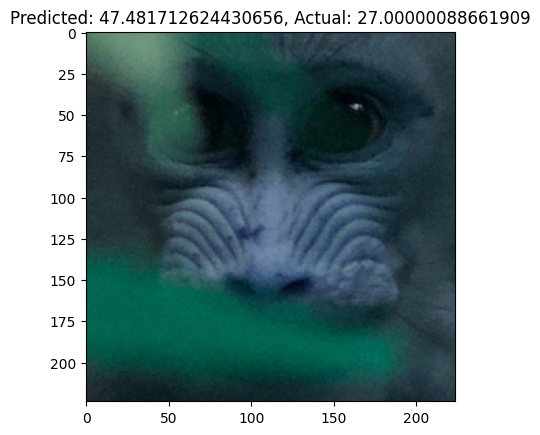

Predicted Values: 314.80876237154007
Actual Values: 342.0000094175339
Prediction Error:  -27.191247045993805



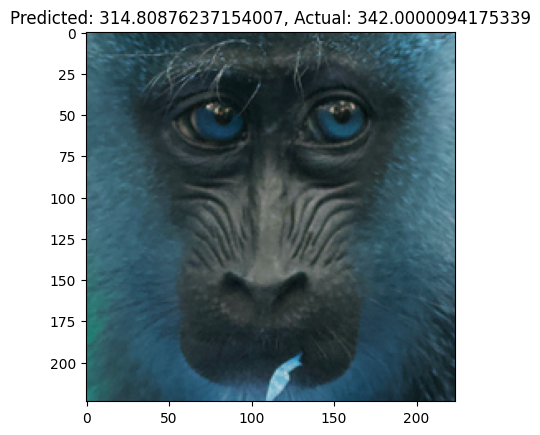

Predicted Values: 8.29679548740387
Actual Values: 10.999999782070518
Prediction Error:  -2.703204294666648



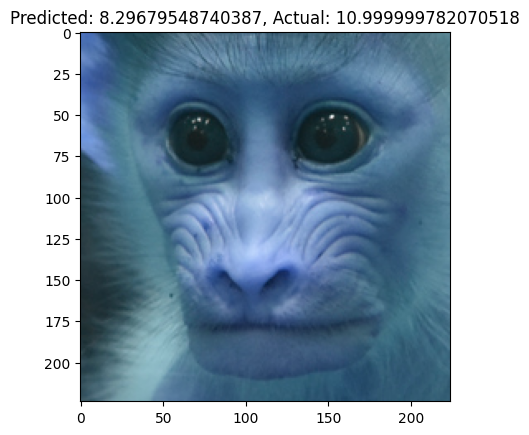

Predicted Values: 8.349207676947117
Actual Values: 0.0
Prediction Error:  8.349207676947117



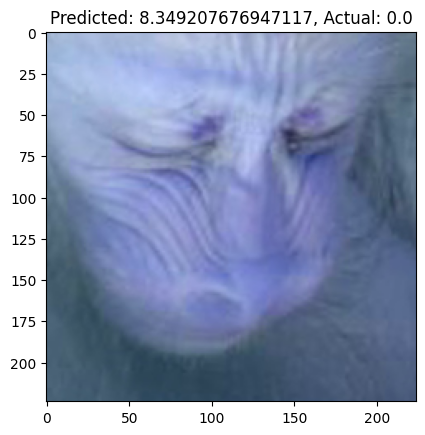

Predicted Values: 231.45046681165695
Actual Values: 262.0000100135803
Prediction Error:  -30.54954320192337



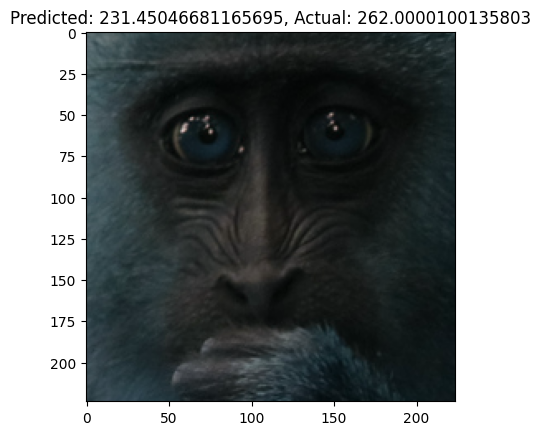

Predicted Values: 137.80958116054535
Actual Values: 131.00000500679016
Prediction Error:  6.809576153755188



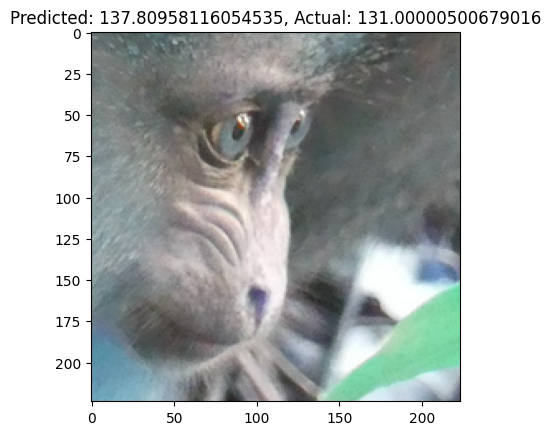

Predicted Values: 79.06393885612488
Actual Values: 76.99999779462814
Prediction Error:  2.0639410614967346



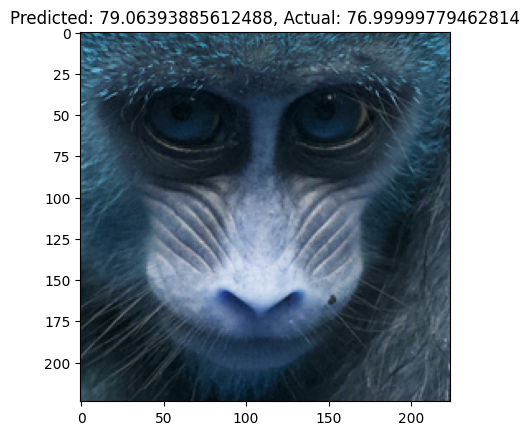

Predicted Values: 142.3087677359581
Actual Values: 165.00000149011612
Prediction Error:  -22.69123375415802



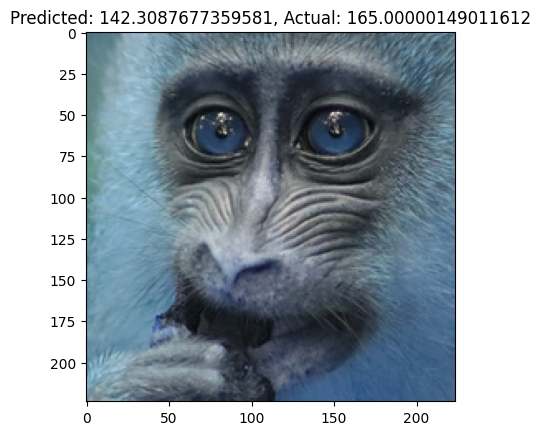

Predicted Values: 287.72805601358414
Actual Values: 350.99999248981476
Prediction Error:  -63.27193647623062



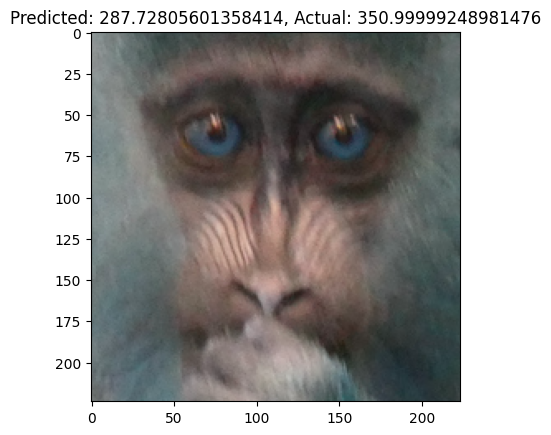

Predicted Values: 99.15789067745209
Actual Values: 123.00000071525574
Prediction Error:  -23.84211003780365



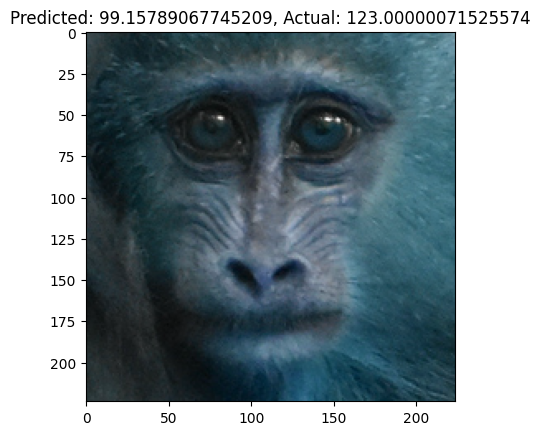

Absolute age error (in days):  -1.5561661558636164  std:  33.9920836762397


In [3]:
import matplotlib.pyplot as plt

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 10

age_errors = []
age_truth = []
age_predicted = []

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    predicted_values = outputs.squeeze().detach().cpu().numpy() * 365
    actual_values = targets.squeeze().cpu().numpy() * 365
    
    age_errors.append(predicted_values - actual_values)
    age_truth.append(actual_values)
    age_predicted.append(predicted_values)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", predicted_values)
    print("Actual Values:", actual_values)
    print("Prediction Error: ", predicted_values - actual_values)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

age_errors = np.array(age_errors)
print("Absolute age error (in days): ", np.mean(age_errors), " std: ", np.std(age_errors))

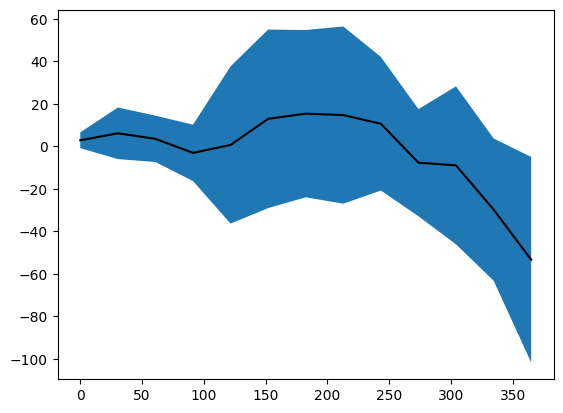

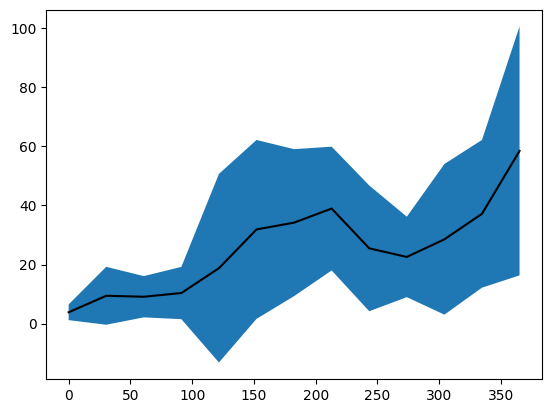

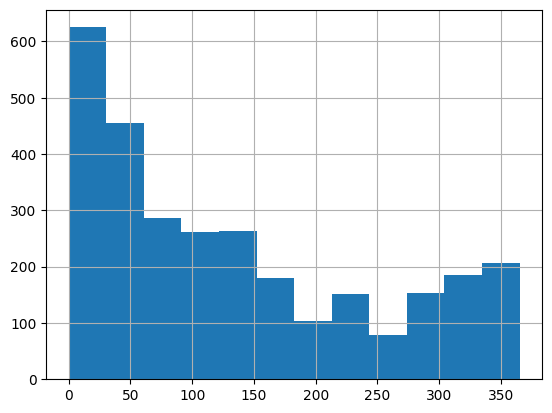

In [4]:
# Histogram with x being the real age and y being the error on this age
# Plotting the histogram

def group_by(x, n_bins):
    step = np.max(x) / n_bins
    x = np.array(x)
    for i in range(n_bins+1):
        nx = i*step
        px = max(0, (i-1)*step)
        x[np.logical_and(x <= nx, x > px)] = nx
    x[np.logical_and(x <= np.max(x), x > (n_bins*step))] = np.max(x)
    return x.tolist()

def bin_errors(x, y):
    bins = np.unique(x)
    y_mean = []
    y_err = []
    y = np.array(y)
    for b in bins:
        y_bin = y[x == b]
        y_mean.append(np.mean(y_bin))
        y_err.append(np.std(y_bin))
    return np.array(y_mean), np.array(y_err)

n_bins = 12

x = age_truth
y = age_errors

sorted_lists = sorted(zip(x, y))
sorted_x, sorted_y = zip(*sorted_lists)

def display_error_curve(x, y, n_bins):
    x = group_by(x, n_bins)
    y, y_err = bin_errors(x, y)
    x = np.unique(x)

    plt.plot(x, y, 'k-', label='Prediction error')
    plt.fill_between(x, y-y_err, y+y_err)
    plt.show()

display_error_curve(sorted_x, sorted_y, n_bins)
display_error_curve(sorted_x, abs(np.array(sorted_y)), n_bins)
# Display the mean value per bin
#for i in range(n_bins):
#    plt.text(x_bins[i], max(x_hist[i], y_hist[i]), f'{x_mean:.2f}', ha='center', va='bottom')
#    plt.text(y_bins[i], max(x_hist[i], y_hist[i]), f'{y_mean:.2f}', ha='center', va='bottom')


# Distribution of image according to the age
hist = one_year_data["age"].hist(bins=n_bins)